# Project - "Finding a good neighborhood for opening a bar in Cologne, Germany"

### Introduction
For this project I collected data of the city of Cologne in Germany in order to give advice to a fictional customer, who wants to open a bar in Cologne and seeks to find an appropriate neighborhood based on specific criteria. The target group of the bar is supposed to be young people (about age 18 to 35). Also it is supposed to be located in an area with many bars in the surrounding and with a high population density. 

My goal is to find the neighborhoods which best fit this criteria. 

In order to run a successful bar the first thing needed are many customers to visit. The rest is up to the good management of the bar. As an estimator for the amount of customers, that visit a bar, I will use the amount of tips, that are listed for each bar in Foursquare. I want to analyze if the chosen criteria are associated with the number of tips for a bar using a correlation analysis. 

### Data Description
I downloaded the data I used for this project from the webpage https://www.offenedaten-koeln.de. Here I found two tables, that are interesting for my research question. One table contains information about age distribution of each neighborhood (https://www.offenedaten-koeln.de/dataset/fdeb99c8-8640-4539-b342-2eeaf06eefc9/resource/3c2bee9a-fc8b-437f-aa18-727e9b8aa5ef#{}). The other table contains information about the density of the population in each neighborhood (https://www.offenedaten-koeln.de/dataset/28b8e786-edde-4744-b245-13439e9c1ed8/resource/eae7348a-309f-4560-9b93-7f8504a9a40e#{}). 

In total there are 86 neighborhoods in cologne. Three neighborhoods were excludes from the analysis, because of missing data for “citizens per square kilometers”. All three neighborhoods have a small population and a small proportion of young people and would not have been interesting for the analysis. 

To get the longitude and latitude for each neighborhood in cologne I used “Nominatim” as a tool. 

I found the nearby bars/pubs of each neighborhood in Cologne with the Foursquare API. I chose a radius of 650 meters for each neighborhood, since increasing the radius would have led to double hits of bars for the neighborhoods. This way I found 52 bras/pubs located in 18 different neighbourhoods. 

In a last step the Foursquare API was used to find the Tip-Count for each bar. 

### Analysis

##### Neihgborhood  characteristics
It might be interesting for the fictive customer to analyse the neighborhood based on their top listed venues to get a better understanding of each neigborhood. I built a dataframe with the top ten venues for each neighborhood.

##### Correlations:
I calculated the correlation matrix of the following variables
- proportion of young people ("percentage 18-34")
- population density" ("citizens per square kilometers")
- number of bars in the neighborhood("Bar/Pub-Count")
- number of tips for each Bar/Pub ("Tip-Count"). 

There is a significant positive correlation with the Tips-Count for all three Variables:
- "Percentage 18-34": r = 0.48)
- "Citizens per square kilometers": r = 0.51)
- "Bar/Pup-Count": r = 0.55)
- There were also high correlations among the three variables

##### Neighborhood selection
To answer the question, which neighborhood would be best suited to open a bar in Cologne I selected all the neighborhoods that have a high Value for “percentage of young people”, “citizens per square kilometers” and "Bar/Pub-Count" (percentile =0.7). This selection can be weighted differently based on the priorities of the fictive costumer. 

### Analysis - Data Preprocessing

importing libraries

In [15]:
import pandas as pd
import numpy as np
import re
from scipy import stats
import geopy
from geopy.geocoders import Nominatim 
import folium 
import requests 
import json
from pandas.io.json import json_normalize 

creating credentials for the foursquare API

In [60]:
CLIENT_ID = ###
CLIENT_SECRET = ### 
VERSION = 20181217 
LIMIT = 100

importing the dataset containing informations about the age distribution 

In [61]:
df_age = pd.read_excel("stadtteile_alter14.xlsx")
#change to anglish column names
df_age.rename(columns={'Stadtteil':'Neighborhood', 'Einwohner insgesamt':'citizens total', '80 und Ã¤lter':'80 and above'}, inplace=True)
#select columns needed
filtered_columns = ['Neighborhood', 'citizens total', '18-20', '21-34']
df_age_f = df_age.loc[:, filtered_columns]
#calculate percentages of the agegroup 18-34
df_age_f["18-34"] = df_age_f["18-20"] + df_age_f["21-34"] 
df_age_f["percentage 18-34"] = df_age_f["18-34"]/ df_age_f["citizens total"] * 100
df_age_f["percentage 18-34"] = df_age_f["percentage 18-34"].round(decimals=2)
df_age_f = df_age_f.drop(['citizens total','18-20','21-34','18-34'], axis=1)

In [62]:
df_age_f.head()

,Neighborhood,percentage 18-34
0,Altstadt-SÃ¼d,35.85
1,Neustadt-SÃ¼d,38.79
2,Altstadt-Nord,36.32
3,Neustadt-Nord,31.01
4,Deutz,31.98


importing the dataset containing informations about the density of the population

In [63]:
df_dense = pd.read_excel("stadtteile_dichte14.xlsx")
#rename to english column names
df_dense.rename(columns={'Stadtteil':'Neighborhood', 'Einwohner je Quadratkilometer':'citizens per square kilometers'}, inplace=True)
#select columns needed
fil_col = ['Neighborhood', 'citizens per square kilometers']
df_dense_f = df_dense.loc[:, fil_col]
df_dense_f.head()

,Neighborhood,citizens per square kilometers
0,Altstadt-SÃ¼d,11678
1,Neustadt-SÃ¼d,13552
2,Altstadt-Nord,7287
3,Neustadt-Nord,8084
4,Deutz,2892


joining the two datasets

In [64]:
df_koeln = df_age_f.join(df_dense_f.set_index('Neighborhood'), on='Neighborhood')
#change to readable strings
df_koeln["Neighborhood"] = df_koeln.Neighborhood.str.replace("Ã¼", "ü")
df_koeln["Neighborhood"] = df_koeln.Neighborhood.str.replace("ÃŸ", "ß")
df_koeln["Neighborhood"] = df_koeln.Neighborhood.str.replace("Ã¶", "ö") 
df_latlon = df_koeln.dropna()
df_latlon.shape

(83, 3)

### Showing a map of Cologne and its neighborhoods

To get the longitude and latitude for each neighborhood in Cologne I used “Nominatim” as a tool.

In [65]:
#creating columns for lat and lon
df_latlon['lat'] = None
df_latlon['lon'] = None

#getting the latitude and longitude for each neighborhood
from geopy.point import Point
bbox = [Point(50.8304494,6.7725303),Point(51.0849743,7.162028)]

for index, row in df_latlon.iterrows():
    try:
        address = '{}, Köln, Deutschland'.format(row["Neighborhood"])
        geolocator = Nominatim(user_agent="test-app",view_box=bbox,bounded=True) 
        location = geolocator.geocode(address)
        df_latlon.loc[index, "lat"] = location.latitude
        df_latlon.loc[index, "lon"] = location.longitude
    except:
        print(row["Neighborhood"], "None-object has no lat/lon")
df_latlon.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,percentage 18-34,citizens per square kilometers,lat,lon
0,Altstadt-Süd,35.85,11678.0,50.9292,6.95533
1,Neustadt-Süd,38.79,13552.0,50.9266,6.94041
2,Altstadt-Nord,36.32,7287.0,50.9423,6.95319
3,Neustadt-Nord,31.01,8084.0,50.9479,6.94106
4,Deutz,31.98,2892.0,50.9368,6.97305


In [66]:
#geting lat and lon of Cologne, Germany
address = 'köln, Deutschland'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_k = location.latitude
longitude_k = location.longitude

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
#creating the map
map_köln= folium.Map(location=[latitude_k, longitude_k], zoom_start=11)
# adding markers to the map
for lat, lng, label in zip(df_latlon['lat'], df_latlon['lon'], df_latlon['Neighborhood']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_köln)  
map_köln

# Getting the nearby venues of Cologne's neighborhoods

I found the nearby venues of each neighborhood in Cologne with the Foursquare API. I chose a radius of 650 meters for each neighborhood, since increasing the radius led to double hits for found bars/pubs. This way I found **1307** venues for all neighborhoods in cologne. 

In [68]:
#here the client secret and ID originally had to be passed

def getNearbyVenues(names, latitudes, longitudes, radius=650):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # creating the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood lat', 
                  'Neighborhood lon', 
                  'Venue',
                  'ID',
                  'Venue lat', 
                  'Venue lon', 
                  'Venue Category']
    
    return(nearby_venues)

In [85]:
köln_venues = getNearbyVenues(names=df_latlon['Neighborhood'],
                                   latitudes=df_latlon['lat'],
                                   longitudes=df_latlon['lon'])

Altstadt-Süd
Neustadt-Süd
Altstadt-Nord
Neustadt-Nord
Deutz
Bayenthal
Marienburg
Raderberg
Raderthal
Zollstock
Rondorf
Hahnwald
Rodenkirchen
Weiß
Sürth
Godorf
Immendorf
Meschenich
Klettenberg
Sülz
Lindenthal
Braunsfeld
Müngersdorf
Junkersdorf
Weiden
Lövenich
Widdersdorf
Ehrenfeld
Neuehrenfeld
Bickendorf
Vogelsang
Ossendorf
Nippes
Mauenheim
Riehl
Niehl
Weidenpesch
Longerich
Bilderstöckchen
Merkenich
Fühlingen
Seeberg
Heimersdorf
Lindweiler
Pesch
Esch/Auweiler
Volkhoven/Weiler
Chorweiler
Blumenberg
Worringen
Poll
Westhoven
Ensen
Gremberghoven
Eil
Porz
Urbach
Elsdorf
Grengel
Wahnheide
Wahn
Lind
Libur
Zündorf
Langel
Finkenberg
Kalk
Vingst
Höhenberg
Ostheim
Merheim
Brück
Rath/Heumar
Neubrück
Mülheim
Buchforst
Buchheim
Holweide
Dellbrück
Höhenhaus
Dünnwald
Stammheim
Flittard


In [86]:
len(köln_venues["ID"].value_counts())
köln_venues.head()

,Neighborhood,Neighborhood lat,Neighborhood lon,Venue,ID,Venue lat,Venue lon,Venue Category
0,Altstadt-Süd,50.929181,6.955329,Motel One Köln-Waidmarkt,50c5f2ca067dc772ebcc0328,50.931557,6.954513,Hotel
1,Altstadt-Süd,50.929181,6.955329,Severin's Kebap Haus,4f565504e4b07893e1d17340,50.928267,6.957587,Turkish Restaurant
2,Altstadt-Süd,50.929181,6.955329,Holiday Inn Express,5922a6d84c954c04e9bcb25d,50.930371,6.953661,Hotel
3,Altstadt-Süd,50.929181,6.955329,Motel One Lounge,50b9c85ce4b0c78357e050fb,50.931571,6.954438,Lounge
4,Altstadt-Süd,50.929181,6.955329,Toscanini,4b464b72f964a520cf1c26e3,50.925644,6.957099,Italian Restaurant


In [87]:
köln_venues.to_csv("köln_venues.csv", index = False)

### Exploring the different neighborhoods and their venues 

In [88]:
köln_venues = pd.read_csv("köln_venues.csv", engine='python')
köln_venues.head()

,Neighborhood,Neighborhood lat,Neighborhood lon,Venue,ID,Venue lat,Venue lon,Venue Category
0,Altstadt-SÃ¼d,50.929181,6.955329,Motel One KÃ¶ln-Waidmarkt,50c5f2ca067dc772ebcc0328,50.931557,6.954513,Hotel
1,Altstadt-SÃ¼d,50.929181,6.955329,Severin's Kebap Haus,4f565504e4b07893e1d17340,50.928267,6.957587,Turkish Restaurant
2,Altstadt-SÃ¼d,50.929181,6.955329,Holiday Inn Express,5922a6d84c954c04e9bcb25d,50.930371,6.953661,Hotel
3,Altstadt-SÃ¼d,50.929181,6.955329,Motel One Lounge,50b9c85ce4b0c78357e050fb,50.931571,6.954438,Lounge
4,Altstadt-SÃ¼d,50.929181,6.955329,Toscanini,4b464b72f964a520cf1c26e3,50.925644,6.957099,Italian Restaurant


In [89]:
köln_venues["Neighborhood"] = köln_venues.Neighborhood.str.replace("Ã¼", "ü")
köln_venues["Neighborhood"] = köln_venues.Neighborhood.str.replace("ÃŸ", "ß")
köln_venues["Neighborhood"] = köln_venues.Neighborhood.str.replace("Ã¶", "ö") 
köln_venues.head()

,Neighborhood,Neighborhood lat,Neighborhood lon,Venue,ID,Venue lat,Venue lon,Venue Category
0,Altstadt-Süd,50.929181,6.955329,Motel One KÃ¶ln-Waidmarkt,50c5f2ca067dc772ebcc0328,50.931557,6.954513,Hotel
1,Altstadt-Süd,50.929181,6.955329,Severin's Kebap Haus,4f565504e4b07893e1d17340,50.928267,6.957587,Turkish Restaurant
2,Altstadt-Süd,50.929181,6.955329,Holiday Inn Express,5922a6d84c954c04e9bcb25d,50.930371,6.953661,Hotel
3,Altstadt-Süd,50.929181,6.955329,Motel One Lounge,50b9c85ce4b0c78357e050fb,50.931571,6.954438,Lounge
4,Altstadt-Süd,50.929181,6.955329,Toscanini,4b464b72f964a520cf1c26e3,50.925644,6.957099,Italian Restaurant


In [90]:
# creating a Dummy variable for every entry of Venue Category
Koeln_onehot = pd.get_dummies(köln_venues[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
Koeln_onehot['Neighborhood'] = köln_venues['Neighborhood'] 

# moving neighborhood column to the first column
fixed_columns = [Koeln_onehot.columns[-1]] + list(Koeln_onehot.columns[:-1])
Koeln_onehot = Koeln_onehot[fixed_columns]

#building the mean for every venue while grouping by Neighborhood
koeln_grouped = Koeln_onehot.groupby('Neighborhood').mean().reset_index()
koeln_grouped.head()

,Neighborhood,ATM,African Restaurant,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Water Park,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Altstadt-Nord,0.0,0.0,0.0,0.0,0.03,0.020000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Altstadt-Süd,0.0,0.0,0.0,0.0,0.00,0.043478,0.000000,0.0,0.0,...,0.021739,0.0,0.0,0.021739,0.000000,0.0,0.0,0.0,0.0,0.0
2,Bayenthal,0.0,0.0,0.0,0.0,0.00,0.000000,0.033333,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0
3,Bickendorf,0.0,0.0,0.0,0.0,0.00,0.000000,0.062500,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Bilderstöckchen,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [91]:
# sort venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#creating a table with the 10 most common venues for each Neighborhood
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# creating columns according to number of top venues
columns = ['Neighborhood']
for i in range(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    except:
        columns.append('{}th Most Common Venue'.format(i+1))

# creating the dataframe
koeln_venues_sorted = pd.DataFrame(columns=columns)
koeln_venues_sorted['Neighborhood'] = koeln_grouped['Neighborhood']

for i in range(koeln_grouped.shape[0]):
    koeln_venues_sorted.iloc[i, 1:] = return_most_common_venues(koeln_grouped.iloc[i, :], num_top_venues)

koeln_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstadt-Nord,Italian Restaurant,German Restaurant,Hotel,CafÃ©,Gift Shop,Gourmet Shop,Bakery,Art Museum,Brewery,Rhenisch Restaurant
1,Altstadt-Süd,Hotel,Sushi Restaurant,Italian Restaurant,German Restaurant,Restaurant,Asian Restaurant,CafÃ©,Building,Seafood Restaurant,Korean Restaurant
2,Bayenthal,Supermarket,Drugstore,Gym / Fitness Center,Bakery,Fish Market,Clothing Store,Organic Grocery,Gourmet Shop,Thai Restaurant,Beer Garden
3,Bickendorf,Supermarket,Burger Joint,Pub,Coffee Shop,Nightclub,CafÃ©,Drugstore,Athletics & Sports,Gym / Fitness Center,Metro Station
4,Bilderstöckchen,Shipping Store,Bakery,Bus Stop,Tram Station,Supermarket,Drugstore,Market,Park,Flea Market,Flower Shop
5,Blumenberg,Light Rail Station,Snack Place,Camera Store,Zoo Exhibit,Fountain,Forest,Food Truck,Food Court,Food & Drink Shop,Food
6,Braunsfeld,Italian Restaurant,Bakery,Supermarket,Gourmet Shop,German Restaurant,Ice Cream Shop,Market,Sushi Restaurant,Thai Restaurant,Lawyer
7,Brück,Supermarket,Hotel,Tram Station,German Restaurant,Thai Restaurant,Beer Garden,Trattoria/Osteria,Paper / Office Supplies Store,Bed & Breakfast,Drugstore
8,Buchforst,Supermarket,Hookah Bar,Gym / Fitness Center,Tunnel,Gas Station,Motorcycle Shop,Fruit & Vegetable Store,Hotel,Liquor Store,Food Court
9,Buchheim,Supermarket,Metro Station,Platform,Greek Restaurant,Turkish Restaurant,German Restaurant,Gym / Fitness Center,Gas Station,Bakery,Brewery


### Exploring the bars/pubs in more detail

In [92]:
# selecting only the venues that contain the words bar or pub
df_n = köln_venues[köln_venues['Venue Category'].str.contains('bar|pub', flags=re.IGNORECASE, regex=True)].reset_index(drop=True)
#rename the columns venue categories to bar/pub
df_n.rename(columns={'Venue Category':'Bar/Pub'}, inplace=True)
#getting rid of the Gastropubs
df_n = df_n[df_n["Bar/Pub"]!= 'Gastropub'].reset_index(drop=True)
df_n.to_csv("Dataframe_cologne_bars.csv", index = False)
print("There are {} Bars/Pubs in the listed neighbourhoods of Köln.".format(df_n.shape[0]))

There are 52 Bars/Pubs in the listed neighbourhoods of Köln.


#### showing the bars of Cologne on a map

In [34]:
map_köln= folium.Map(location=[latitude_k, longitude_k], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_n['Venue lat'], df_n['Venue lon'], df_n['Venue']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_köln)  
    
map_köln

In [93]:
#merging the datastes 
df_merge = df_n.join(df_latlon.set_index('Neighborhood'), on='Neighborhood', lsuffix ="_df_n")
df_merge.drop(['Neighborhood lat','Neighborhood lon', 'Venue lat', 'Venue lon', 'lat', 'lon' ], axis=1, inplace=True)

In [94]:
df_merge.head()

,Neighborhood,Venue,ID,Bar/Pub,percentage 18-34,citizens per square kilometers
0,Altstadt-Süd,Em TresÃ¶rche,4e0f859cd22d8582bdc9c18f,Bar,35.85,11678.0
1,Neustadt-Süd,Stereo Wonderland,4b05886af964a52066c422e3,Bar,38.79,13552.0
2,Neustadt-Süd,Acephale,5593146a498ebeb40755d43e,Bar,38.79,13552.0
3,Neustadt-Süd,Zwoeinz,4b50c41cf964a5207e3127e3,Bar,38.79,13552.0
4,Neustadt-Süd,Roter Platz,4bf855be4a67c928453e25cf,Bar,38.79,13552.0


create new dataframe with bar-count for each neighborhood

In [95]:
#add bar-count to the dataframe
df_bars = df_n.groupby(["Neighborhood"])[['Bar/Pub']].count().reset_index()
df_merge2 = df_merge.join(df_bars.set_index('Neighborhood'), on='Neighborhood', lsuffix ="_df_merge")
df_merge2.rename(columns={'Bar/Pub_df_merge':'Bar/Pub - Type', 'Bar/Pub':'Bar/Pub - Count'}, inplace=True)
df_merge2.shape

(52, 7)

In [96]:
df_merge2.head()

,Neighborhood,Venue,ID,Bar/Pub - Type,percentage 18-34,citizens per square kilometers,Bar/Pub - Count
0,Altstadt-Süd,Em TresÃ¶rche,4e0f859cd22d8582bdc9c18f,Bar,35.85,11678.0,1
1,Neustadt-Süd,Stereo Wonderland,4b05886af964a52066c422e3,Bar,38.79,13552.0,14
2,Neustadt-Süd,Acephale,5593146a498ebeb40755d43e,Bar,38.79,13552.0,14
3,Neustadt-Süd,Zwoeinz,4b50c41cf964a5207e3127e3,Bar,38.79,13552.0,14
4,Neustadt-Süd,Roter Platz,4bf855be4a67c928453e25cf,Bar,38.79,13552.0,14


### Getting the Tip -Count for each Bar/Pub from Foursquare API



In [35]:
#because of call limits for Foursquare API - getting information about the first 40 rows
#check1=[]
#for index, row in df_merge2.iterrows():
#    if index <= 40:
#        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row["ID"], CLIENT_ID, CLIENT_SECRET, VERSION)
#        results = requests.get(url).json()["response"]
#        print(results)
#        check1.append(results["venue"]["id"])
#        check1.append(results["venue"]["stats"]["tipCount"])        

{'venue': {'id': '4e0f859cd22d8582bdc9c18f', 'name': 'Em Tresörche', 'contact': {'phone': '+491772801999', 'formattedPhone': '+49 177 2801999'}, 'location': {'address': 'An St. Katharinen 2', 'lat': 50.925036, 'lng': 6.958212, 'labeledLatLngs': [{'label': 'display', 'lat': 50.925036, 'lng': 6.958212}], 'postalCode': '50678', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['An St. Katharinen 2', '50678 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/em-tres%C3%B6rche/4e0f859cd22d8582bdc9c18f', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}}], 'verified': Fals

{'venue': {'id': '5593146a498ebeb40755d43e', 'name': 'Acephale', 'contact': {}, 'location': {'address': 'Luxemburger Str. 46', 'lat': 50.926391, 'lng': 6.938786, 'labeledLatLngs': [{'label': 'display', 'lat': 50.926391, 'lng': 6.938786}], 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Luxemburger Str. 46', 'Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/acephale/5593146a498ebeb40755d43e', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 9, 'groups': [{'type': 'others', 'count': 9, 'items': [{'id': '12688148', 'firstName': 'Maria', 'lastName': 'Shishkina', 'gender': 'female', 'photo': {'prefix': 'https://fastly.4sqi.ne

{'venue': {'id': '4bf855be4a67c928453e25cf', 'name': 'Roter Platz', 'contact': {'phone': '+492214767951', 'formattedPhone': '+49 221 4767951'}, 'location': {'address': 'Zülpicher Platz 11', 'lat': 50.929857824719484, 'lng': 6.939570299383194, 'labeledLatLngs': [{'label': 'display', 'lat': 50.929857824719484, 'lng': 6.939570299383194}], 'postalCode': '50674', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Zülpicher Platz 11', '50674 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/roter-platz/4bf855be4a67c928453e25cf', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d109941735', 'name': 'Eastern European Restaurant', 'pluralName': 'Eastern European Restaurants', 'shortName': 'Eastern European', 'icon': {'prefix': 'https

{'venue': {'id': '4dcda89552b1f8915b82f8ad', 'name': 'Soul Bar', 'contact': {'phone': '+4922116913067', 'formattedPhone': '+49 221 16913067', 'facebook': '214600318568377', 'facebookUsername': 'SoulBarCologne', 'facebookName': 'Soul Bar Cologne'}, 'location': {'address': 'Zülpicher Str. 29', 'lat': 50.9291255382931, 'lng': 6.9373284925208365, 'labeledLatLngs': [{'label': 'display', 'lat': 50.9291255382931, 'lng': 6.9373284925208365}], 'postalCode': '50674', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Zülpicher Str. 29', '50674 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/soul-bar/4dcda89552b1f8915b82f8ad', 'categories': [{'id': '4bf58dd8d48988d11e941735', 'name': 'Cocktail Bar', 'pluralName': 'Cocktail Bars', 'shortName': 'Cocktail', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 21}, 'url'

{'venue': {'id': '4b05886bf964a520b2c422e3', 'name': 'Stiefel', 'contact': {'phone': '+491713596982', 'formattedPhone': '+49 171 3596982', 'twitter': 'stiefel_koeln', 'instagram': 'stiefel_koeln'}, 'location': {'address': 'Zülpicher Str. 18', 'crossStreet': 'Heinsbergstr.', 'lat': 50.92989277233793, 'lng': 6.938389241695404, 'labeledLatLngs': [{'label': 'display', 'lat': 50.92989277233793, 'lng': 6.938389241695404}], 'postalCode': '50674', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Zülpicher Str. 18 (Heinsbergstr.)', '50674 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/stiefel/4b05886bf964a520b2c422e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11f941735', 'name': 'Nightclub', 'pluralName': 'Nightclubs', 

{'venue': {'id': '4b06b601f964a520edee22e3', 'name': 'Metronom', 'contact': {'phone': '+49221213465', 'formattedPhone': '+49 221 213465', 'facebook': '692531344206371', 'facebookUsername': 'metronom', 'facebookName': 'Metronom Köln'}, 'location': {'address': 'Weyerstr. 59', 'lat': 50.93038298801195, 'lng': 6.943511094785877, 'labeledLatLngs': [{'label': 'display', 'lat': 50.93038298801195, 'lng': 6.943511094785877}], 'postalCode': '50676', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Weyerstr. 59', '50676 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/metronom/4b06b601f964a520edee22e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 12}, 'url': 'http://www.metronom.koeln', 'price': {'tier': 1, 

{'venue': {'id': '4b05886af964a5206cc422e3', 'name': 'Pacific Bar', 'contact': {'phone': '+492219231160', 'formattedPhone': '+49 221 9231160', 'twitter': 'pacific_bar', 'facebook': '230556016970237', 'facebookUsername': 'pacificbar.cologne', 'facebookName': 'Pacific Bar - Cologne'}, 'location': {'address': 'Kyffhäuserstr. 17', 'lat': 50.92885604571345, 'lng': 6.939631431065375, 'labeledLatLngs': [{'label': 'display', 'lat': 50.92885604571345, 'lng': 6.939631431065375}], 'postalCode': '50674', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kyffhäuserstr. 17', '50674 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/pacific-bar/4b05886af964a5206cc422e3', 'categories': [{'id': '4bf58dd8d48988d11e941735', 'name': 'Cocktail Bar', 'pluralName': 'Cocktail Bars', 'shortName': 'Cocktail', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'venue': {'id': '4b4e2e6ef964a52058e426e3', 'name': 'Tankstelle', 'contact': {'phone': '+4922116818855', 'formattedPhone': '+49 221 16818855'}, 'location': {'address': 'Kyffhäuser Str. 19', 'lat': 50.92883392112204, 'lng': 6.939523556484949, 'labeledLatLngs': [{'label': 'display', 'lat': 50.92883392112204, 'lng': 6.939523556484949}], 'postalCode': '50674', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kyffhäuser Str. 19', '50674 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/tankstelle/4b4e2e6ef964a52058e426e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11d941735', 'name': 'Sports Bar', 'pluralName': 'Sports Bars', 'shortName': 'Sports Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlif

{'venue': {'id': '4b183fbef964a5208fcf23e3', 'name': 'Shepheard', 'contact': {'phone': '+492213310994', 'formattedPhone': '+49 221 3310994', 'facebook': '154231917943917', 'facebookName': 'Shepheard'}, 'location': {'address': 'Rathenauplatz 5', 'lat': 50.93073313106366, 'lng': 6.93733833138825, 'labeledLatLngs': [{'label': 'display', 'lat': 50.93073313106366, 'lng': 6.93733833138825}], 'postalCode': '50674', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Rathenauplatz 5', '50674 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/shepheard/4b183fbef964a5208fcf23e3', 'categories': [{'id': '4bf58dd8d48988d11e941735', 'name': 'Cocktail Bar', 'pluralName': 'Cocktail Bars', 'shortName': 'Cocktail', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d121941735', 'name': 'Lounge', 'pluralName': 'Lounges', 'shortName': 'Lounge', 'i

{'venue': {'id': '4b05886bf964a520a7c422e3', 'name': 'Flotte', 'contact': {'phone': '+49221211689', 'formattedPhone': '+49 221 211689'}, 'location': {'address': 'Zülpicher Platz 9', 'lat': 50.92996918082704, 'lng': 6.939781281848672, 'labeledLatLngs': [{'label': 'display', 'lat': 50.92996918082704, 'lng': 6.939781281848672}], 'postalCode': '50674', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Zülpicher Platz 9', '50674 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/flotte/4b05886bf964a520a7c422e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'url': 'http://www.dieflotte.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 21, 'groups': [{'type': 'others', 'c

{'venue': {'id': '4b05886cf964a520cbc422e3', 'name': 'Boogaloo', 'contact': {'phone': '+491777844858', 'formattedPhone': '+49 177 7844858', 'facebook': '158407107520449', 'facebookName': 'Boogaloo Köln'}, 'location': {'address': 'Roonstr. 19', 'lat': 50.9299344, 'lng': 6.9399194, 'labeledLatLngs': [{'label': 'display', 'lat': 50.9299344, 'lng': 6.9399194}], 'postalCode': '50674', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Roonstr. 19', '50674 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/boogaloo/4b05886cf964a520cbc422e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 19, 'groups': [{'type': 'others', 'count':

{'venue': {'id': '4b88d965f964a520531032e3', 'name': 'Trierer Eck', 'contact': {'phone': '+492212405748', 'formattedPhone': '+49 221 2405748'}, 'location': {'address': 'Trierer Str. 21', 'lat': 50.927743738577846, 'lng': 6.945447288439526, 'labeledLatLngs': [{'label': 'display', 'lat': 50.927743738577846, 'lng': 6.945447288439526}], 'postalCode': '50676', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Trierer Str. 21', '50676 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/trierer-eck/4b88d965f964a520531032e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'url': 'http://www.trierer-eck.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 13, 'groups': [{'type': 

{'venue': {'id': '51921bf7498e6750b2f7dccb', 'name': 'Die Vitamin-Oase', 'contact': {'phone': '+491713802435', 'formattedPhone': '+49 171 3802435', 'facebook': '700216996995314', 'facebookUsername': 'vitaminoasekoeln', 'facebookName': 'Die Vitamin - Oase'}, 'location': {'address': 'Andreaskloster 16', 'lat': 50.942347793982776, 'lng': 6.955118834675627, 'labeledLatLngs': [{'label': 'display', 'lat': 50.942347793982776, 'lng': 6.955118834675627}], 'postalCode': '50667', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Andreaskloster 16', '50667 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/die-vitaminoase/51921bf7498e6750b2f7dccb', 'categories': [{'id': '4bf58dd8d48988d112941735', 'name': 'Juice Bar', 'pluralName': 'Juice Bars', 'shortName': 'Juice Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/juicebar_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1bd941735', 'name': '

{'venue': {'id': '4cb9a036dd41a35d2cb5e2a0', 'name': 'Divas', 'contact': {'phone': '+4922116230', 'formattedPhone': '+49 221 16230', 'twitter': 'hotel_savoy', 'instagram': 'savoy_hotel_cologne', 'facebook': '129793022366', 'facebookUsername': 'HotelSavoy', 'facebookName': 'Hotel Savoy'}, 'location': {'address': 'Turiner Str. 9', 'lat': 50.946436235842214, 'lng': 6.957340735113447, 'labeledLatLngs': [{'label': 'display', 'lat': 50.946436235842214, 'lng': 6.957340735113447}], 'postalCode': '50668', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Turiner Str. 9', '50668 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/divas/4cb9a036dd41a35d2cb5e2a0', 'categories': [{'id': '4bf58dd8d48988d1d5941735', 'name': 'Hotel Bar', 'pluralName': 'Hotel Bars', 'shortName': 'Hotel Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_bar_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f106

{'venue': {'id': '4b094ca5f964a520621523e3', 'name': "Barney Vallely's", 'contact': {}, 'location': {'address': 'Kleine Budengasse 7', 'lat': 50.939144710206385, 'lng': 6.958821457319325, 'labeledLatLngs': [{'label': 'display', 'lat': 50.939144710206385, 'lng': 6.958821457319325}], 'postalCode': '50667', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kleine Budengasse 7', '50667 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/barney-vallelys/4b094ca5f964a520621523e3', 'categories': [{'id': '52e81612bcbc57f1066b7a06', 'name': 'Irish Pub', 'pluralName': 'Irish Pubs', 'shortName': 'Irish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'likes': {'count': 47, 'groups': [{'type': 'others', 'count': 47, 'items': []}], 'summary': '47 Likes'}, 'dislike': False, 'ok': False, 'rating': 7.4, 'ratingColor': 'C

{'venue': {'id': '4b05886bf964a52086c422e3', 'name': 'Weißer Holunder', 'contact': {'phone': '+4922194526500', 'formattedPhone': '+49 221 94526500', 'facebook': '138486839537754', 'facebookName': 'Weißer Holunder'}, 'location': {'address': 'Gladbacher Str. 48', 'crossStreet': 'Erftstr.', 'lat': 50.94649411474652, 'lng': 6.938427328611663, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94649411474652, 'lng': 6.938427328611663}], 'postalCode': '50672', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Gladbacher Str. 48 (Erftstr.)', '50672 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/wei%C3%9Fer-holunder/4b05886bf964a52086c422e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'http://

{'venue': {'id': '4a172db1f964a52039791fe3', 'name': 'Mc Lennon', 'contact': {}, 'location': {'address': 'Hansaring 32', 'lat': 50.94643646810345, 'lng': 6.945808747857014, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94643646810345, 'lng': 6.945808747857014}], 'postalCode': '50670', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Hansaring 32', '50670 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/mc-lennon/4a172db1f964a52039791fe3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 24, 'groups': [{'type': 'others', 'count': 24, 'items': []}], 'summary': '24 Likes'}, 'dislike': False, 'ok': False, 'rating': 7.3, '

{'venue': {'id': '4b05886bf964a520bbc422e3', 'name': 'Legends Bar', 'contact': {'phone': '+4922182811775', 'formattedPhone': '+49 221 82811775', 'twitter': 'hyattcologne', 'instagram': 'hyattregencycologne', 'facebook': '494846500566473', 'facebookUsername': 'HyattRegencyKoeln', 'facebookName': 'Hyatt Regency Köln'}, 'location': {'address': 'Kennedy-Ufer 2a', 'lat': 50.940639981807315, 'lng': 6.9689930574902315, 'labeledLatLngs': [{'label': 'display', 'lat': 50.940639981807315, 'lng': 6.9689930574902315}], 'postalCode': '50679', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kennedy-Ufer 2a', '50679 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/legends-bar/4b05886bf964a520bbc422e3', 'categories': [{'id': '4bf58dd8d48988d1d5941735', 'name': 'Hotel Bar', 'pluralName': 'Hotel Bars', 'shortName': 'Hotel Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_bar_', 'suffix': '.png'}, 'pri

{'venue': {'id': '5186b4a4498e67377267a64e', 'name': 'Kumkapi', 'contact': {'phone': '+4915779033118', 'formattedPhone': '+49 1577 9033118'}, 'location': {'address': 'Marktstr. 10', 'lat': 50.91111579079394, 'lng': 6.957917849921685, 'labeledLatLngs': [{'label': 'display', 'lat': 50.91111579079394, 'lng': 6.957917849921685}], 'postalCode': '5067', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Marktstr. 10', '5067 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/kumkapi/5186b4a4498e67377267a64e', 'categories': [{'id': '4bf58dd8d48988d119941735', 'name': 'Hookah Bar', 'pluralName': 'Hookah Bars', 'shortName': 'Hookah Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/hookahbar_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count': 10, 'i

{'venue': {'id': '4eebb31fbe7be63d1e869e8f', 'name': 'My Way', 'contact': {'phone': '+492212828747', 'formattedPhone': '+49 221 2828747', 'facebook': '175729545793308', 'facebookUsername': 'mywaykoeln', 'facebookName': 'My Way'}, 'location': {'address': 'Aachener Str. 419', 'lat': 50.936777130288654, 'lng': 6.907797876757186, 'labeledLatLngs': [{'label': 'display', 'lat': 50.936777130288654, 'lng': 6.907797876757186}], 'postalCode': '50933', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Aachener Str. 419', '50933 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/my-way/4eebb31fbe7be63d1e869e8f', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'url': 'http://www.veedelskneipe.de', 'price': {'tier

{'venue': {'id': '4b05886af964a5204dc422e3', 'name': 'Königsblut', 'contact': {'phone': '+491632878660', 'formattedPhone': '+49 163 2878660'}, 'location': {'address': 'Thebäerstr. 8', 'lat': 50.946968666592525, 'lng': 6.921688870468963, 'labeledLatLngs': [{'label': 'display', 'lat': 50.946968666592525, 'lng': 6.921688870468963}], 'postalCode': '50823', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Thebäerstr. 8', '50823 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/k%C3%B6nigsblut/4b05886af964a5204dc422e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 49, 'groups': [{'type': 'others', 'count': 49, 'items': []}]

{'venue': {'id': '4b43b65ff964a5204be725e3', 'name': 'Die hängenden Gärten von Ehrenfeld', 'contact': {'phone': '+492215892338', 'formattedPhone': '+49 221 5892338', 'twitter': 'diegaerten', 'facebook': '211680196545', 'facebookUsername': 'haengendegaerten', 'facebookName': 'Die hängenden Gärten von Ehrenfeld'}, 'location': {'address': 'Vogelsanger Str. 140', 'lat': 50.94733969928145, 'lng': 6.91661920910181, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94733969928145, 'lng': 6.91661920910181}], 'postalCode': '50823', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Vogelsanger Str. 140', '50823 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/die-h%C3%A4ngenden-g%C3%A4rten-von-ehrenfeld/4b43b65ff964a5204be725e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.

{'venue': {'id': '58791a7752a05106f28f71f4', 'name': 'Bumann & Sohn', 'contact': {}, 'location': {'address': 'Bartholomäus-Schink-Str. 2', 'lat': 50.95211480469088, 'lng': 6.918134706967542, 'labeledLatLngs': [{'label': 'display', 'lat': 50.95211480469088, 'lng': 6.918134706967542}], 'postalCode': '50825', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Bartholomäus-Schink-Str. 2', '50825 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/bumann--sohn/58791a7752a05106f28f71f4', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'url': 'https://www.bumannundsohn.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 64, 'groups': [{'type': 'others', 'count': 64, 'items': []}

{'venue': {'id': '4f1ffcfce4b02792a7731c50', 'name': 'Secco', 'contact': {'phone': '+492215505200', 'formattedPhone': '+49 221 5505200'}, 'location': {'address': 'Simrockstr. 2', 'lat': 50.9477430118881, 'lng': 6.922661135037987, 'labeledLatLngs': [{'label': 'display', 'lat': 50.9477430118881, 'lng': 6.922661135037987}], 'postalCode': '50823', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Simrockstr. 2', '50823 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/secco/4f1ffcfce4b02792a7731c50', 'categories': [{'id': '4bf58dd8d48988d123941735', 'name': 'Wine Bar', 'pluralName': 'Wine Bars', 'shortName': 'Wine Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/winery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'url': 'http://www.weinlokalsecco.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 19, 'groups': [{'type': 'oth

{'venue': {'id': '4d6085ac5c39b1f79978054a', 'name': '"L"', 'contact': {}, 'location': {'address': 'Hüttenstr. 24', 'lat': 50.952229, 'lng': 6.920724, 'labeledLatLngs': [{'label': 'display', 'lat': 50.952229, 'lng': 6.920724}], 'postalCode': '50825', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Hüttenstr. 24', '50825 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/l/4d6085ac5c39b1f79978054a', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d118941735', 'name': 'Dive Bar', 'pluralName': 'Dive Bars', 'shortName': 'Dive Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/divebar_', 'suffix': '.png'}}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency

{'venue': {'id': '4c912b75ae45224ba08ce597', 'name': 'Point One', 'contact': {'facebook': '108821022515833', 'facebookName': 'Point One'}, 'location': {'address': 'Venloer Str. 219', 'lat': 50.94641527520146, 'lng': 6.924877568043869, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94641527520146, 'lng': 6.924877568043869}], 'postalCode': '50823', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Venloer Str. 219', '50823 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/point-one/4c912b75ae45224ba08ce597', 'categories': [{'id': '4bf58dd8d48988d11d941735', 'name': 'Sports Bar', 'pluralName': 'Sports Bars', 'shortName': 'Sports Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/sportsbar_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub

{'venue': {'id': '4d59a4a84d9a721e945b430e', 'name': 'Moselstübchen', 'contact': {}, 'location': {'address': 'Landmannstr. 3', 'lat': 50.95496970117678, 'lng': 6.918120706488246, 'labeledLatLngs': [{'label': 'display', 'lat': 50.95496970117678, 'lng': 6.918120706488246}], 'postalCode': '50825', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Landmannstr. 3', '50825 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/moselst%C3%BCbchen/4d59a4a84d9a721e945b430e', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 7, 'groups': [{'type': 'others', 'count': 7, 'items': [{'id': '27660768', 'firstName': 'Gerd', 'lastName': 'Schnitzl

{'venue': {'id': '4dab0a724b22f071eac4e087', 'name': 'Effi', 'contact': {}, 'location': {'address': 'Nußbaumer Str. 86', 'lat': 50.95778326418903, 'lng': 6.9231271856554075, 'labeledLatLngs': [{'label': 'display', 'lat': 50.95778326418903, 'lng': 6.9231271856554075}], 'postalCode': '50823', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Nußbaumer Str. 86', '50823 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/effi/4dab0a724b22f071eac4e087', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'url': 'http://www.effi-koeln.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 2, 'groups': [{'type': 'others', 'count': 2, 'items': [{'id': '402664929', 'firstName': 'Lukas',

{'venue': {'id': '4bf996f91134b7138e480fc9', 'name': 'Im Rondellchen', 'contact': {'phone': '+492215302192', 'formattedPhone': '+49 221 5302192'}, 'location': {'address': 'Akazienweg 54', 'crossStreet': 'Erlenweg', 'lat': 50.963213947865114, 'lng': 6.89433624340805, 'labeledLatLngs': [{'label': 'display', 'lat': 50.963213947865114, 'lng': 6.89433624340805}], 'postalCode': '50827', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Akazienweg 54 (Erlenweg)', '50827 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/im-rondellchen/4bf996f91134b7138e480fc9', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d10d941735', 'name': 'German Restaurant', 'pluralName': 'German Restaurants', 'shortName': 'German', 'icon': {'prefix': 'htt

In [101]:
# because of call limits for Foursquare API - getting information about the remaining rows
#check2 = []
#for index, row in df_merge2.iterrows():
#    if index >40:
#        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row["ID"], CLIENT_ID, CLIENT_SECRET, VERSION)
#        results = requests.get(url).json()["response"]
#        print(results)
#        check2.append(results["venue"]["id"])
#        check2.append(results["venue"]["stats"]["tipCount"]) 

{'venue': {'id': '4b867e8df964a520818c31e3', 'name': 'Basil‘s', 'contact': {'phone': '+492217601510', 'formattedPhone': '+49 221 7601510', 'facebook': '110088579145237', 'facebookUsername': 'basilsnippes', 'facebookName': "Basil's"}, 'location': {'address': 'Bülowstr. 21', 'lat': 50.96565750101084, 'lng': 6.9563225006136244, 'labeledLatLngs': [{'label': 'display', 'lat': 50.96565750101084, 'lng': 6.9563225006136244}], 'postalCode': '50733', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Bülowstr. 21', '50733 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/basils/4b867e8df964a520818c31e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'

{'venue': {'id': '4b05886cf964a520f4c422e3', 'name': 'Kuen', 'contact': {'phone': '+491636970599', 'formattedPhone': '+49 163 6970599', 'facebook': '282385778553281', 'facebookName': 'Kuen'}, 'location': {'address': 'Kuenstr. 9', 'lat': 50.96123175109119, 'lng': 6.956400201987955, 'labeledLatLngs': [{'label': 'display', 'lat': 50.96123175109119, 'lng': 6.956400201987955}], 'postalCode': '50733', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kuenstr. 9', '50733 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/kuen/4b05886cf964a520f4c422e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nigh

{'venue': {'id': '4dd7d9ca2271c5d36d450370', 'name': 'Barfly', 'contact': {'phone': '+491738683894', 'formattedPhone': '+49 173 8683894'}, 'location': {'address': 'Kempener Str. 68', 'lat': 50.96426893872246, 'lng': 6.94846732289814, 'labeledLatLngs': [{'label': 'display', 'lat': 50.96426893872246, 'lng': 6.94846732289814}], 'postalCode': '50733', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kempener Str. 68', '50733 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/barfly/4dd7d9ca2271c5d36d450370', 'categories': [{'id': '4bf58dd8d48988d11e941735', 'name': 'Cocktail Bar', 'pluralName': 'Cocktail Bars', 'shortName': 'Cocktail', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 10}, 'url': 'http://www.barfly-cologne.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 27

{'venue': {'id': '4e6a7c8645ddadf2d07edd35', 'name': 'Heimathirsch', 'contact': {'phone': '+4922116917800', 'formattedPhone': '+49 221 16917800'}, 'location': {'address': 'Mauenheimer Str. 4', 'lat': 50.96558050203743, 'lng': 6.9529521980864075, 'labeledLatLngs': [{'label': 'display', 'lat': 50.96558050203743, 'lng': 6.9529521980864075}], 'postalCode': '50733', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Mauenheimer Str. 4', '50733 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/heimathirsch/4e6a7c8645ddadf2d07edd35', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'url': 'http://heimathirschnippes.jimdo.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 14, 

{'venue': {'id': '4ef351b28b81368cf951c24d', 'name': 'Alt Neppes', 'contact': {'phone': '+49221767116', 'formattedPhone': '+49 221 767116', 'facebook': '150161471844847', 'facebookUsername': 'AltNeppes', 'facebookName': 'Alt Neppes'}, 'location': {'address': 'Neusser Str. 301', 'lat': 50.965486, 'lng': 6.953364, 'labeledLatLngs': [{'label': 'display', 'lat': 50.965486, 'lng': 6.953364}], 'postalCode': '50733', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Neusser Str. 301', '50733 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/alt-neppes/4ef351b28b81368cf951c24d', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'http://www.alt-neppes.de', 'price': {'tier': 1, 'message': 'Cheap', 'curre

{'venue': {'id': '51295c49e4b0d0a7cc8e2562', 'name': 'treff', 'contact': {}, 'location': {'address': 'Waldstraße', 'lat': 50.884521484375, 'lng': 7.092195510864258, 'labeledLatLngs': [{'label': 'display', 'lat': 50.884521484375, 'lng': 7.092195510864258}], 'cc': 'DE', 'country': 'Deutschland', 'formattedAddress': ['Waldstraße', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/treff/51295c49e4b0d0a7cc8e2562', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'allowMenuUrlEdit': True, 'beenHere': {'count': 0, 'unconfirmedCount': 0, 'marked': False, 'lastCheckinExpiredAt': 0}, 'specials': {'count': 0, 'items': []}, 'photos': {'count': 0, 'gro

{'venue': {'id': '4e7a27adae60757c75965e4d', 'name': 'Sokrates', 'contact': {}, 'location': {'lat': 50.94044794643589, 'lng': 7.025948363205328, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94044794643589, 'lng': 7.025948363205328}], 'postalCode': '51103', 'cc': 'DE', 'city': 'Köln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['51103 Köln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/sokrates/4e7a27adae60757c75965e4d', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'c

In [40]:
#safe lists to csv
#import csv

#with open('check_650_1.csv',"w") as csvfile:
#    writer =csv.writer(csvfile, quotechar='|')
#    writer.writerow(check1)
#    
#with open('check_650_2.csv',"w") as csvfile:
#    writer =csv.writer(csvfile, quotechar='|')
#    writer.writerow(check2)

In [97]:
#load lists with information about ID and Tip-Count for each bar and adding the two lists
import csv
check_imp1= []
with open('check_650_1.csv') as csvfile:
    reader = csv.reader(csvfile)
    for i in reader:
        check_imp1.append(i)
check_imp1= [x for x in check_imp1 if x][0]

check_imp2 = []
with open('check_650_2.csv') as csvfile:
    reader = csv.reader(csvfile)
    for i in reader:
        check_imp2.append(i)
check_imp2= [x for x in check_imp2 if x][0]

check_add = check_imp1 + check_imp2

In [98]:
#creating a dataframe of ID and Tip-Count
list_id = check_add[0::2]
list_tips = check_add[1::2]
df_tipcount = pd.DataFrame({"ID":list_id, "Tip-Count":list_tips})
df_tipcount.shape

(52, 2)

adding df_tipcount to df_merge2

In [104]:
df_corr = df_merge2.join(df_tipcount.set_index('ID'), on='ID', lsuffix ="_df_merge2")
df_corr["Tip-Count"].dropna(axis=0, inplace = True)
df_corr.head()

,Neighborhood,Venue,ID,Bar/Pub - Type,percentage 18-34,citizens per square kilometers,Bar/Pub - Count,Tip-Count
0,Altstadt-Süd,Em TresÃ¶rche,4e0f859cd22d8582bdc9c18f,Bar,35.85,11678.0,1,5
1,Neustadt-Süd,Stereo Wonderland,4b05886af964a52066c422e3,Bar,38.79,13552.0,14,10
2,Neustadt-Süd,Acephale,5593146a498ebeb40755d43e,Bar,38.79,13552.0,14,1
3,Neustadt-Süd,Zwoeinz,4b50c41cf964a5207e3127e3,Bar,38.79,13552.0,14,9
4,Neustadt-Süd,Roter Platz,4bf855be4a67c928453e25cf,Bar,38.79,13552.0,14,24


In [105]:
df_corr["Tip-Count"] =df_corr["Tip-Count"].astype("int64")

### Correlation - Analysis

In [106]:
#Calculating the correlations
corr = df_corr.corr()
corr

,percentage 18-34,citizens per square kilometers,Bar/Pub - Count,Tip-Count
percentage 18-34,1.000000,0.673254,0.756146,0.485048
citizens per square kilometers,0.673254,1.000000,0.851680,0.515314
Bar/Pub - Count,0.756146,0.851680,1.000000,0.554675
Tip-Count,0.485048,0.515314,0.554675,1.000000


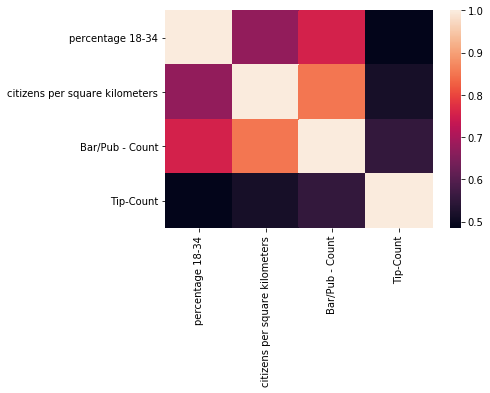

In [107]:
# plotting the heatmap
import seaborn as sns
%matplotlib inline
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Choosing a good Neighborhood

In [108]:
df_merge2.head()

,Neighborhood,Venue,ID,Bar/Pub - Type,percentage 18-34,citizens per square kilometers,Bar/Pub - Count
0,Altstadt-Süd,Em TresÃ¶rche,4e0f859cd22d8582bdc9c18f,Bar,35.85,11678.0,1
1,Neustadt-Süd,Stereo Wonderland,4b05886af964a52066c422e3,Bar,38.79,13552.0,14
2,Neustadt-Süd,Acephale,5593146a498ebeb40755d43e,Bar,38.79,13552.0,14
3,Neustadt-Süd,Zwoeinz,4b50c41cf964a5207e3127e3,Bar,38.79,13552.0,14
4,Neustadt-Süd,Roter Platz,4bf855be4a67c928453e25cf,Bar,38.79,13552.0,14


In [109]:
df_choose = df_merge2.drop(columns=["Venue", 'ID','Bar/Pub - Type'], axis = 1)
df_choose= df_choose.groupby(df_choose["Neighborhood"]).aggregate({'percentage 18-34': 'first', 'citizens per square kilometers': 'first', 'Bar/Pub - Count':'first'})

In [110]:
young = df_choose['percentage 18-34']>=  df_choose.quantile(q=0.7)[0]
dense = df_choose['citizens per square kilometers'] >= df_choose.quantile(q=0.7)[1]
bars = df_choose['Bar/Pub - Count'] >= df_choose.quantile(q=0.7)[2]
df_select = df_choose[young & dense & bars] 

In [111]:
df_select

,percentage 18-34,citizens per square kilometers,Bar/Pub - Count
Neighborhood,,,
Ehrenfeld,35.15,9759.0,9
Neustadt-Süd,38.79,13552.0,14
